In [2]:
import os
import sys
custom_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(f"Added {os.path.abspath(path)} to path")

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
import os
import ast

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

import misc
reload(misc)

<module 'misc' from '/nfs/home/cybai/PyTorch-StudioGAN/notebooks/misc.py'>

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [5]:
cifar10_1_dset = cifar10_1.CIFAR10_1_v6('../data/cifar10_1',
                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(0.5, 0.5)]), 
                                         download=True) # range = [-1, 1]
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifar10_test_dset = datasets.CIFAR10('../data/cifar10', train=False, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifair10_dset = cifair.ciFAIR10('../data/cifair10', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(0.5, 0.5)]), 
                                download=True) # range = [-1, 1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
ref_dsets = {'cifar10_1': cifar10_1_dset, 'cifar10_train': cifar10_train_dset,
                'cifar10_test': cifar10_test_dset, 'cifair10': cifair10_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [7]:
proj_models = {
    'inception_v3': inception.WrappedInception3(custom_num_classes=10),
    'vgg13_bn': vgg.wrapped_vgg13_bn(custom_num_classes=10),
    'alexnet': alexnet.WrappedAlexNet(custom_num_classes=10)
}

##### trainable parameters
AuxLogits.fc.weight	AuxLogits.fc.bias	fc.weight	fc.bias	
#####
##### trainable parameters
None	None	
#####
##### trainable parameters
None	None	
#####


In [8]:
def finetune(model, dl, save_model_path=None):
    n_epochs = 30
    lr = 0.001
    momentum = 0.9
    optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], 
                                 lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(n_epochs):
        n_corrects, n_totals = 0, 0

        for x, y in dl:

            optimizer.zero_grad()

            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            if len(outputs) == 2:
                loss = criterion(outputs[1], y)
            elif len(outputs) == 3:
                loss = criterion(outputs[1], y) + 0.4 * criterion(outputs[2], y)

            loss.backward()
            optimizer.step()

            # statistics
            _, preds = torch.max(outputs[1], 1)
            n_corrects += torch.sum(preds == y).item()
            n_totals += y.shape[0]

        epoch_acc = n_corrects / n_totals
        scheduler.step()
    
        print(f'epoch {epoch + 1}: acc = {epoch_acc}')
    
    if save_model_path is not None:
        torch.save(model.state_dict(), save_model_path)
    
    return model

In [9]:
for model_name, model in proj_models.items():
    save_path = f"finetuned_{model_name}.pth"
    if os.path.isfile(save_path):
        print(f"{save_path} exists")
        proj_models[model_name].load_state_dict(torch.load(save_path))
        proj_models[model_name].eval().to(device)
        continue
    finetune(model.train().to(device), ref_dls['cifar10_train'], save_model_path=save_path)
    proj_models[model_name].eval().to(device)

finetuned_inception_v3.pth exists
finetuned_vgg13_bn.pth exists
finetuned_alexnet.pth exists


In [21]:
sagan_runs = {
    0.00: ['SAGAN-train-2021_03_04_15_20_57', 'SAGAN-train-2021_03_09_00_54_36', 'SAGAN-train-2021_03_10_10_00_29', 'SAGAN-train-2021_03_17_13_42_52'],
    0.10: ['SAGAN-train-2021_03_06_00_44_13', 'SAGAN-train-2021_03_09_00_57_09', 'SAGAN-train-2021_03_11_10_38_54', 'SAGAN-train-2021_03_18_13_59_54'],
    0.12: ['SAGAN-train-2021_03_06_00_46_59', 'SAGAN-train-2021_03_09_01_00_30', 'SAGAN-train-2021_03_12_11_16_43', 'SAGAN-train-2021_03_28_13_20_51'],
    0.13: ['SAGAN-train-2021_03_06_00_48_39', 'SAGAN-train-2021_03_09_02_08_08', 'SAGAN-train-2021_03_13_11_47_27', 'SAGAN-train-2021_03_28_13_21_53'],
    0.14: ['SAGAN-train-2021_03_06_00_50_43', 'SAGAN-train-2021_03_27_11_48_10', 'SAGAN-train-2021_03_14_12_23_07', 'SAGAN-train-2021_03_28_13_30_23'],
    0.15: ['SAGAN-train-2021_03_06_00_54_20', 'SAGAN-train-2021_03_27_11_51_51', 'SAGAN-train-2021_03_15_12_50_35', 'SAGAN-train-2021_04_03_16_07_22'],
    0.16: ['SAGAN-train-2021_03_06_00_57_47', 'SAGAN-train-2021_03_27_11_53_44', 'SAGAN-train-2021_03_16_13_20_09', 'SAGAN-train-2021_04_03_16_10_52']
}

In [23]:
gen_feats, gen_probs = {}, {}
for model_name, proj_model in proj_models.items():
    print(f'Processing projection {model_name}...')
    gen_feats_, gen_probs_ = {}, {}
    for mrt, runnames in sagan_runs.items():
        gen_feats_[mrt], gen_probs_[mrt] = [], []
        for runname in runnames:
            generator = misc.wrapper_best(runname=runnames[0], dset_name='CIFAR10', device=device)
            (xs_, ys_), feats_, probs_ = misc.project(generator, proj_model, n_samples=10000, 
                                                      to_numpy=True, return_logits=False)
            gen_feats_[mrt].append(feats_)
            gen_probs_[mrt].append(probs_)
    gen_feats[model_name], gen_probs[model_name] = gen_feats_, gen_probs_

Processing projection inception_v3...


KeyboardInterrupt: 

In [ ]:
gen_inception_stats = {k: {k_: [(np.mean(v__, axis=0), np.cov(v__, rowvar=False)) for v__ in v_] 
                           for k_, v_ in v.items()}
                       for k, v in gen_feats.items()}

In [17]:
ref_feats = {}
for model_name, proj_model in proj_models.items():
    print(f'Processing projection {model_name}...')
    ref_feats_ = {}
    for dset_name, ref_dl in ref_dls.items():
        (xs_, ys_), feats_, probs_ = misc.project(ref_dl, proj_model, n_samples=None, 
                                                  to_numpy=True, return_logits=False)
        ref_feats_[dset_name] = feats_
    ref_feats[model_name] = ref_feats_

Processing projection inception_v3...
Processing projection vgg13_bn...
Processing projection alexnet...


In [19]:
ref_inception_stats = {k: {k_: (np.mean(v_, axis=0), np.cov(v_, rowvar=False)) 
                           for k_, v_ in v.items()}
                       for k, v in ref_feats.items()}

In [ ]:
proj_model_name = 'inception_v3'

In [ ]:
fids = {}
for proj_model_name in proj_models.keys():
    fids_ = {}
    for dset_name in ref_dls.keys():
        for mrt in gen_feats[proj_model_name].keys():
            fid = calculate_frechet_distance(mu, cov, dset_inception_means[dset_name], 
                                             dset_inception_covs[dset_name])

In [6]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device, requires_grad=False).view(-1, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=device, requires_grad=False).view(-1, 1, 1)

In [7]:
cifar10_mean = torch.tensor([0.4914, 0.4822, 0.4465], device=device, requires_grad=False).view(-1, 1, 1)
cifar10_std = torch.tensor([0.2471, 0.2435, 0.2616], device=device, requires_grad=False).view(-1, 1, 1)

In [8]:
imagenet_inception = models.inception_v3(pretrained=True).eval().to(device)
cifar10_inception = cifar10_models.inception_v3(pretrained=True).eval().to(device)

In [9]:
models_dict = {
    'imagenet_inception': imagenet_inception,
    'cifar10_inception': cifar10_inception
}

In [237]:
model_name = 'imagenet_inception'
mean = imagenet_mean
std = imagenet_std

In [238]:
train_imagenet = []
model, handle = misc.register_hook(model_name, models_dict, train_imagenet, cast_numpy=False)

with torch.no_grad():
    for x, y in train_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        pred_logits = model(x)
        '''
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        '''

handle.remove()
train_imagenet = torch.cat(train_imagenet, axis=0)
print(train_imagenet.shape)

torch.Size([50000, 2048])


In [239]:
handle.remove()

In [240]:
train_imagenet = torch.div(train_imagenet, torch.norm(train_imagenet, dim=1).view(-1, 1))

In [241]:
test_imagenet = []
conf_imagenet = []
model, handle = misc.register_hook(model_name, models_dict, test_imagenet, cast_numpy=False)

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        pred_logits = model(x)
        
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        conf_imagenet.append(pred_topkconf[:, 0])

handle.remove()
test_imagenet = torch.cat(test_imagenet, axis=0)
conf_imagenet = torch.cat(conf_imagenet, axis=0)
print(test_imagenet.shape, conf_imagenet.shape)

0.3488442897796631 0.0980614647269249
0.35736051201820374 0.07991498708724976
0.33580562472343445 0.08538089692592621
0.36074575781822205 0.08768016844987869
0.4144904613494873 0.08756157010793686
0.37626704573631287 0.07953536510467529
0.31744450330734253 0.09006695449352264
0.3585180640220642 0.09675302356481552
0.3352425992488861 0.09034225344657898
0.3794073164463043 0.07532768696546555
0.314341276884079 0.08104734122753143
0.41357189416885376 0.07699812203645706
0.41190093755722046 0.09144584089517593
0.38685065507888794 0.08860606700181961
0.37150076031684875 0.09285726398229599
0.34119558334350586 0.09283823519945145
0.4083016812801361 0.07845442742109299
0.3164813220500946 0.08872857689857483
0.35993632674217224 0.09274111688137054
0.4007790982723236 0.09453286975622177
0.3639150857925415 0.0764031931757927
0.3508848547935486 0.08435037732124329
0.424357146024704 0.08056817948818207
0.4427664875984192 0.08383799344301224
0.33949869871139526 0.09317365288734436
0.384155452251434

In [242]:
handle.remove()

In [243]:
min_val, min_idx = misc.compute_memorization_distance(test_imagenet, train_imagenet)

In [244]:
min_val = min_val.detach().cpu().numpy()
conf_imagenet = conf_imagenet.detach().cpu().numpy()

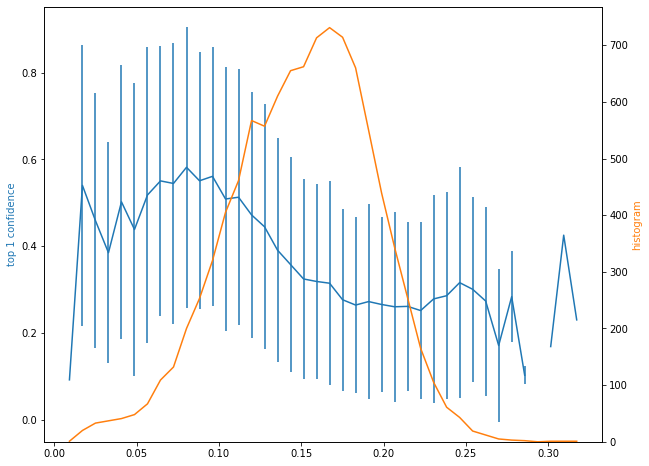

In [246]:
bins = 40
mean_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'mean', bins=bins)
std_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'std', bins=bins)
count_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'count', bins=bins)
fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(binedges[:-1], mean_stats, yerr=std_stats, color='tab:blue')
# ax.tick_params(axis='y', colors='tab:blue')
ax.set_ylabel('top 1 confidence', color='tab:blue')

ax_twin = ax.twinx()
ax_twin.plot(binedges[:-1], count_stats, color='tab:orange')
# ax_twin.tick_params(axis='y', colors='tab:orange')
ax_twin.set_ylabel('histogram', color='tab:orange')
ax_twin.set_ylim(0, None)
# plt.savefig('memdist-quality(inception_v3_pretrained_imagenet).pdf', bbox_inches='tight')

### CIFAR10 Inception_v3

In [247]:
model_name = 'cifar10_inception'
mean = cifar10_mean
std = cifar10_std

In [248]:
train_cifar10 = []
model, handle = misc.register_hook(model_name, models_dict, train_cifar10, cast_numpy=False)

with torch.no_grad():
    for x, y in train_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        pred_logits = model(x)
        # '''
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        # '''

handle.remove()
train_cifar10 = torch.cat(train_cifar10, axis=0)

0.966824471950531 0.006782712880522013
0.9630699157714844 0.009633093141019344
0.9647721648216248 0.009089408442378044
0.9669193029403687 0.0061722565442323685
0.9687281847000122 0.005727714393287897
0.9656074047088623 0.0069378698244690895
0.9695757627487183 0.005298715550452471
0.9667559862136841 0.005928881000727415
0.9694239497184753 0.0055988505482673645
0.9683734178543091 0.006127449218183756
0.9641691446304321 0.008741923607885838
0.9694218039512634 0.005186239257454872
0.9478088021278381 0.014087018556892872
0.966519832611084 0.007421085610985756
0.9525641202926636 0.016483915969729424
0.9699008464813232 0.0052660140208899975
0.9702985286712646 0.004945759195834398
0.9633410573005676 0.007353360299021006
0.9678555130958557 0.006392231211066246
0.9643247723579407 0.008185384795069695
0.9660462737083435 0.006726955994963646
0.9660294055938721 0.006051253527402878
0.9652467966079712 0.007239642087370157
0.9674100875854492 0.005885828752070665
0.9697846174240112 0.00515099102631211

0.9598302841186523 0.008088645525276661
0.964002788066864 0.008580377325415611
0.9689922332763672 0.0058540659956634045
0.967340350151062 0.0062543535605072975
0.9602470397949219 0.012135136872529984
0.9639341235160828 0.007980176247656345
0.9669795036315918 0.005838313139975071
0.9628934264183044 0.007321537472307682
0.9628225564956665 0.009648725390434265
0.9683367609977722 0.005792172625660896
0.9663114547729492 0.006887450814247131
0.9683091044425964 0.006160768214613199
0.9687497615814209 0.005810338072478771
0.9637982249259949 0.007090756203979254
0.9529535174369812 0.019071480259299278
0.9582595825195312 0.011648591607809067
0.9672355651855469 0.006946257781237364
0.9650136232376099 0.008322278968989849
0.9649842381477356 0.007323328871279955
0.9599366784095764 0.01387713197618723
0.9651021957397461 0.008270868100225925
0.9673370718955994 0.0065933819860219955
0.9700901508331299 0.004860937595367432
0.9706957936286926 0.005364937707781792
0.9620527625083923 0.010366194881498814


0.953504741191864 0.014983137138187885
0.967147707939148 0.007418595254421234
0.9691282510757446 0.005277670454233885
0.96235591173172 0.007988838478922844
0.9671078324317932 0.006734887603670359
0.9602848887443542 0.010277047753334045
0.9670563340187073 0.007173537276685238
0.949654221534729 0.017853114753961563
0.9693596363067627 0.005427122116088867
0.9687307476997375 0.006382444873452187
0.9664541482925415 0.006426373962312937
0.9529458284378052 0.011500992812216282
0.960304319858551 0.008723222650587559
0.9558035731315613 0.008859562687575817
0.968251645565033 0.005653711035847664
0.9576329588890076 0.012071345932781696
0.9599488377571106 0.010916698724031448
0.9654356241226196 0.0076231202110648155
0.9697587490081787 0.005404985044151545
0.9641540050506592 0.008379721082746983
0.9675678610801697 0.005799026228487492
0.9666842222213745 0.0066180662252008915
0.96616530418396 0.0067008910700678825
0.9663626551628113 0.007327773608267307
0.9684030413627625 0.006490556988865137
0.9689

0.9620413780212402 0.00998697243630886
0.9623199105262756 0.008669700473546982
0.9666917324066162 0.007474435493350029
0.9690243601799011 0.006283794995397329
0.9688410758972168 0.005622361321002245
0.9695389270782471 0.005579209420830011
0.9686776399612427 0.006293331738561392
0.9659523367881775 0.007528606336563826
0.9672977924346924 0.006333405617624521
0.9639602303504944 0.007992539554834366
0.9681092500686646 0.006007028743624687
0.9632421731948853 0.00890559796243906
0.9674180150032043 0.006838577799499035
0.9687950015068054 0.005683610215783119
0.9685136675834656 0.0055750897154212
0.9631988406181335 0.007748380769044161
0.9522988200187683 0.010828172788023949
0.9676413536071777 0.005858653225004673
0.9682445526123047 0.005633290857076645
0.9655354619026184 0.007047419901937246
0.9650214314460754 0.006988802924752235
0.9647287726402283 0.0066873119212687016
0.9692429304122925 0.005304963327944279
0.9684908986091614 0.005806459113955498
0.9661300182342529 0.007227989379316568
0.9

0.9591579437255859 0.008973507210612297
0.9651591181755066 0.007656049448996782
0.9659467935562134 0.007102833595126867
0.9643234610557556 0.008148056454956532
0.9665619730949402 0.0062953028827905655
0.9675560593605042 0.0066392794251441956
0.9656362533569336 0.006777733564376831
0.959822952747345 0.011984727345407009
0.9618266224861145 0.009885336272418499
0.9673104882240295 0.0059518152847886086
0.9666339159011841 0.006257542874664068
0.9572939276695251 0.012866836041212082
0.9626100063323975 0.008949638344347477
0.9664985537528992 0.007273499388247728
0.96675044298172 0.006509225349873304
0.9612967371940613 0.009866966865956783
0.9640225172042847 0.0077539426274597645
0.964273989200592 0.00920034945011139
0.9614036083221436 0.00960028637200594
0.967953085899353 0.00655565969645977
0.960948646068573 0.009515972808003426
0.9668812155723572 0.00679769879207015
0.9588168263435364 0.012988611124455929
0.9665464758872986 0.006922942120581865
0.9652395248413086 0.007497764658182859
0.9579

In [249]:
handle.remove()

In [250]:
train_cifar10 = torch.div(train_cifar10, torch.norm(train_cifar10, dim=1).view(-1, 1))

In [251]:
test_cifar10 = []
model, handle = misc.register_hook(model_name, models_dict, test_cifar10, cast_numpy=False)

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        pred_logits = model(x)
        # '''
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        # '''

handle.remove()
test_cifar10 = torch.cat(test_cifar10, axis=0)
print(test_cifar10.shape)

0.956079363822937 0.014388174749910831
0.9425674080848694 0.02348036877810955
0.9500277638435364 0.02054315246641636
0.9250492453575134 0.036317020654678345
0.934974193572998 0.026424748823046684
0.9498919248580933 0.018214374780654907
0.9367844462394714 0.03176530450582504
0.9444583058357239 0.02251601405441761
0.959406852722168 0.011248013935983181
0.9404232501983643 0.024164346978068352
0.9490365386009216 0.016977518796920776
0.9551409482955933 0.015693407505750656
0.9398733377456665 0.022978881374001503
0.935542643070221 0.025574252009391785
0.9367424845695496 0.028888702392578125
0.9362162351608276 0.027433207258582115
0.945723295211792 0.021710652858018875
0.9354153871536255 0.029394255951046944
0.9151887893676758 0.0411515049636364
0.9399065971374512 0.025844696909189224
0.9473823308944702 0.016303688287734985
0.9340110421180725 0.02572484500706196
0.9512174725532532 0.010317344218492508
0.9270350933074951 0.03308464586734772
0.9438796639442444 0.019850434735417366
0.94616162776

In [252]:
handle.remove()

In [253]:
min_val, min_idx = misc.compute_memorization_distance(test_cifar10, train_cifar10)

In [254]:
min_val = min_val.detach().cpu().numpy()

In [255]:
remove_perc = 0.01
remove_t = np.sort(min_val)[int((1 - remove_perc) * min_val.shape[0])]
print(remove_t)

0.03239733


In [256]:
(min_val > remove_t).sum() / min_val.size

0.0099

In [257]:
min_val[min_val > remove_t] = np.nan

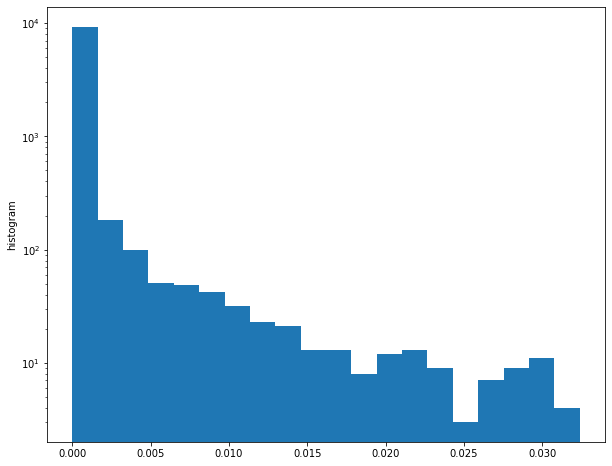

In [260]:
plt.figure(figsize=(10, 8))
plt.hist(min_val, bins=20)
plt.yscale('log')
plt.ylabel('histogram')
plt.savefig('memdist_histogram(cifar10_train_inception_pretrained_cifar10).pdf', bbox_inches='tight')

### Finetune Inception_v3 pretrained on imagenet on cifar10
resources
* https://github.com/creafz/pytorch-cnn-finetune/blob/master/examples/cifar10.py
* https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [191]:
finetune_model = models.inception_v3(pretrained=True)
for param in finetune_model.parameters():
    param.requires_grad = False
finetune_model.fc = torch.nn.Linear(finetune_model.fc.in_features, 10)
finetune_model.AuxLogits.fc = torch.nn.Linear(finetune_model.AuxLogits.fc.in_features, 10)
finetune_model = finetune_model.to(device)

In [192]:
params_to_update = []
for name, param in finetune_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [193]:
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(params_to_update, lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975)
criterion = torch.nn.CrossEntropyLoss()

In [194]:
def train(n_epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + n_epochs):
    
        n_corrects = 0
        n_totals = 0

        for x, y in train_dl:
            optimizer.zero_grad()

            x = x.to(device)
            x = (x + 1.0) / 2.0
            x = (x - imagenet_mean) / imagenet_std
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)

            y = y.to(device)

            outputs, aux_outputs = finetune_model(x)
            loss1 = criterion(outputs, y)
            loss2 = criterion(aux_outputs, y)
            loss = loss1 + 0.4 * loss2

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            # statistics
            n_corrects += torch.sum(preds == y.data).double()
            n_totals += y.data.shape[0]

        epoch_acc = n_corrects / n_totals
        print(f'epoch {epoch}: acc = {epoch_acc}')

        scheduler.step()

In [195]:
n_epochs = 500
train(n_epochs, start_epoch=1)

epoch 2: acc = 0.6865800000000001
epoch 3: acc = 0.6964600000000001
epoch 4: acc = 0.7027800000000001
epoch 5: acc = 0.7076
epoch 6: acc = 0.7112200000000001
epoch 7: acc = 0.7146800000000001
epoch 8: acc = 0.7157000000000001
epoch 9: acc = 0.7165600000000001
epoch 10: acc = 0.7167600000000001
epoch 11: acc = 0.7188000000000001
epoch 12: acc = 0.71752
epoch 13: acc = 0.72028
epoch 14: acc = 0.72072
epoch 15: acc = 0.7203600000000001
epoch 16: acc = 0.7207600000000001
epoch 17: acc = 0.7208800000000001
epoch 18: acc = 0.7213
epoch 19: acc = 0.7227800000000001
epoch 20: acc = 0.72206
epoch 21: acc = 0.7232000000000001
epoch 22: acc = 0.7266600000000001
epoch 23: acc = 0.72208
epoch 24: acc = 0.7228000000000001
epoch 25: acc = 0.7255600000000001
epoch 26: acc = 0.7233
epoch 27: acc = 0.7268600000000001
epoch 28: acc = 0.72562
epoch 29: acc = 0.72614
epoch 30: acc = 0.7240000000000001
epoch 31: acc = 0.7245600000000001
epoch 32: acc = 0.7266400000000001
epoch 33: acc = 0.72206
epoch 34: ac

epoch 272: acc = 0.72462
epoch 273: acc = 0.73028
epoch 274: acc = 0.7285200000000001
epoch 275: acc = 0.73004
epoch 276: acc = 0.7279800000000001
epoch 277: acc = 0.72984
epoch 278: acc = 0.7280800000000001
epoch 279: acc = 0.7292200000000001
epoch 280: acc = 0.7276
epoch 281: acc = 0.72884
epoch 282: acc = 0.7259800000000001
epoch 283: acc = 0.72874
epoch 284: acc = 0.72674
epoch 285: acc = 0.72926
epoch 286: acc = 0.7287600000000001
epoch 287: acc = 0.72814
epoch 288: acc = 0.72804
epoch 289: acc = 0.72562
epoch 290: acc = 0.72972
epoch 291: acc = 0.7284400000000001
epoch 292: acc = 0.7278600000000001
epoch 293: acc = 0.7296800000000001
epoch 294: acc = 0.73026
epoch 295: acc = 0.7284600000000001
epoch 296: acc = 0.7302200000000001
epoch 297: acc = 0.72806
epoch 298: acc = 0.7266
epoch 299: acc = 0.7285200000000001
epoch 300: acc = 0.72584
epoch 301: acc = 0.72858
epoch 302: acc = 0.72696
epoch 303: acc = 0.7294400000000001
epoch 304: acc = 0.72918
epoch 305: acc = 0.72906
epoch 306

In [206]:
torch.save(finetune_model, 'inception_v3_finetune_epoch500.pb')

In [201]:
from_scratch_model = models.inception_v3(pretrained=True)
for param in from_scratch_model.parameters():
    param.requires_grad = True
from_scratch_model.fc = torch.nn.Linear(from_scratch_model.fc.in_features, 10)
from_scratch_model.AuxLogits.fc = torch.nn.Linear(from_scratch_model.AuxLogits.fc.in_features, 10)
from_scratch_model = from_scratch_model.to(device)

In [202]:
params_to_update = []
for name, param in from_scratch_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.branch3x3dbl_3.bn.

In [203]:
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(params_to_update, lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975)
criterion = torch.nn.CrossEntropyLoss()

In [204]:
def train(n_epochs, start_epoch=1):
    for epoch in range(start_epoch, start_epoch + n_epochs):
    
        n_corrects = 0
        n_totals = 0

        for x, y in train_dl:
            optimizer.zero_grad()

            x = x.to(device)
            x = (x + 1.0) / 2.0
            x = (x - imagenet_mean) / imagenet_std
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)

            y = y.to(device)

            outputs, aux_outputs = from_scratch_model(x)
            loss1 = criterion(outputs, y)
            loss2 = criterion(aux_outputs, y)
            loss = loss1 + 0.4 * loss2

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            # statistics
            n_corrects += torch.sum(preds == y.data).double()
            n_totals += y.data.shape[0]

        epoch_acc = n_corrects / n_totals
        print(f'epoch {epoch}: acc = {epoch_acc}')

        scheduler.step()

In [205]:
n_epochs = 10
train(n_epochs, start_epoch=1)

epoch 1: acc = 0.8484600000000001
epoch 2: acc = 0.96462
epoch 3: acc = 0.99106
epoch 4: acc = 0.99848
epoch 5: acc = 0.9997
epoch 6: acc = 0.9998800000000001
epoch 7: acc = 0.99994
epoch 8: acc = 0.9999800000000001
epoch 9: acc = 0.9999800000000001
epoch 10: acc = 1.0


In [207]:
torch.save(from_scratch_model, 'inception_v3_update_all_epoch10.pb')

### Perform Analysis

In [208]:
# finetune_model = torch.load('inception_v3_finetune_epoch500.pb').to(device)
# from_scratch_model = torch.load('inception_v3_update_all_epoch10.pb').to(device)
finetune_model.eval()
from_scratch_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [209]:
models_dict.update({
    'imagenet_inception_finetune': finetune_model,
    'imagenet_inception_from_scratch': from_scratch_model
})

###### Finetune Inception v3

In [210]:
model_name = 'imagenet_inception_finetune'
mean = imagenet_mean
std = imagenet_std

In [211]:
train_imagenet = []
model, handle = misc.register_hook(model_name, models_dict, train_imagenet, cast_numpy=False)

with torch.no_grad():
    for x, y in train_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        pred_logits = model(x)
        '''
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        '''

handle.remove()
train_imagenet = torch.cat(train_imagenet, axis=0)
print(train_imagenet.shape)

torch.Size([50000, 2048])


In [212]:
handle.remove()

In [213]:
train_imagenet = torch.div(train_imagenet, torch.norm(train_imagenet, dim=1).view(-1, 1))

In [214]:
test_imagenet = []
conf_imagenet = []
model, handle = misc.register_hook(model_name, models_dict, test_imagenet, cast_numpy=False)

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        pred_logits = model(x)
        
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        conf_imagenet.append(pred_topkconf[:, 0])

handle.remove()
test_imagenet = torch.cat(test_imagenet, axis=0)
conf_imagenet = torch.cat(conf_imagenet, axis=0)
print(test_imagenet.shape, conf_imagenet.shape)

0.7684879899024963 0.11807558685541153
0.7007272839546204 0.15420208871364594
0.6856049299240112 0.1538316011428833
0.710517406463623 0.14308848977088928
0.7400482296943665 0.13539409637451172
0.6979671120643616 0.14514374732971191
0.7335003614425659 0.138945072889328
0.7233540415763855 0.14364434778690338
0.6878824234008789 0.17770659923553467
0.6921516060829163 0.1655287891626358
0.7882726192474365 0.11396149545907974
0.7557591199874878 0.1194077879190445
0.7040528655052185 0.1541604995727539
0.7551052570343018 0.13502605259418488
0.7032393217086792 0.16500358283519745
0.7335793375968933 0.14489495754241943
0.7490505576133728 0.12491468340158463
0.6899244785308838 0.1607295423746109
0.7390249371528625 0.13007612526416779
0.7472591996192932 0.12764063477516174
0.7217360734939575 0.1489773690700531
0.7725909352302551 0.13269385695457458
0.7462632060050964 0.13687263429164886
0.7741960883140564 0.1228925883769989
0.7619848251342773 0.13917306065559387
0.7341534495353699 0.14838054776191

In [215]:
handle.remove()

In [216]:
min_val, min_idx = misc.compute_memorization_distance(test_imagenet, train_imagenet)

In [217]:
min_val = min_val.detach().cpu().numpy()
conf_imagenet = conf_imagenet.detach().cpu().numpy()

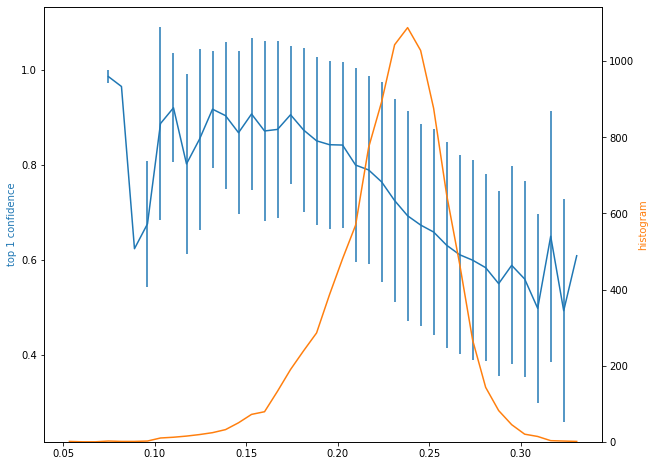

In [226]:
bins = 40
mean_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'mean', bins=bins)
std_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'std', bins=bins)
count_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'count', bins=bins)
fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(binedges[:-1], mean_stats, yerr=std_stats, color='tab:blue')
# ax.tick_params(axis='y', colors='tab:blue')
ax.set_ylabel('top 1 confidence', color='tab:blue')

ax_twin = ax.twinx()
ax_twin.plot(binedges[:-1], count_stats, color='tab:orange')
# ax_twin.tick_params(axis='y', colors='tab:orange')
ax_twin.set_ylabel('histogram', color='tab:orange')
ax_twin.set_ylim(0, None)
# plt.savefig('memdist-quality(inception_v3_finetune).pdf', bbox_inches='tight')

###### From scratch model

In [227]:
model_name = 'imagenet_inception_from_scratch'
mean = imagenet_mean
std = imagenet_std

In [228]:
train_imagenet = []
model, handle = misc.register_hook(model_name, models_dict, train_imagenet, cast_numpy=False)

with torch.no_grad():
    for x, y in train_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        pred_logits = model(x)
        '''
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        '''

handle.remove()
train_imagenet = torch.cat(train_imagenet, axis=0)
print(train_imagenet.shape)

torch.Size([50000, 2048])


In [229]:
handle.remove()

In [230]:
train_imagenet = torch.div(train_imagenet, torch.norm(train_imagenet, dim=1).view(-1, 1))

In [231]:
test_imagenet = []
conf_imagenet = []
model, handle = misc.register_hook(model_name, models_dict, test_imagenet, cast_numpy=False)

with torch.no_grad():
    for x, y in test_dl:
        x = x.to(device)
        x = (x + 1.0) / 2.0
        x = (x - mean) / std
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=True)
        pred_logits = model(x)
        
        pred_softmax = F.softmax(pred_logits, dim=-1)
        pred_topkconf = torch.topk(pred_softmax, k=2, dim=-1, largest=True, sorted=True).values
        print(pred_topkconf[:, 0].mean().item(), pred_topkconf[:, 1].mean().item())
        conf_imagenet.append(pred_topkconf[:, 0])

handle.remove()
test_imagenet = torch.cat(test_imagenet, axis=0)
conf_imagenet = torch.cat(conf_imagenet, axis=0)
print(test_imagenet.shape, conf_imagenet.shape)

0.9904537200927734 0.007729089818894863
0.9882174730300903 0.008351597934961319
0.9911887645721436 0.008665732108056545
0.9885633587837219 0.00946448277682066
0.9830290079116821 0.016174588352441788
0.9994235038757324 0.0005039338138885796
0.9858235716819763 0.013696015812456608
0.9569564461708069 0.035809557884931564
0.9947510957717896 0.00489495974034071
0.9825527667999268 0.015981055796146393
0.9989094138145447 0.0008280890178866684
0.998797595500946 0.0008829968282952905
0.9835718870162964 0.015117475762963295
0.9838631749153137 0.01597730629146099
0.9915971159934998 0.0077004143968224525
0.9848847985267639 0.014179223217070103
0.9961898326873779 0.0030422736890614033
0.9713514447212219 0.01850966177880764
0.9951748251914978 0.004281940404325724
0.9865797162055969 0.006972430273890495
0.998492419719696 0.0013747686753049493
0.9906172156333923 0.009226805530488491
0.9923396110534668 0.006856848951429129
0.992887556552887 0.00682072015479207
0.9996283650398254 0.0002643656625878066
0

In [232]:
handle.remove()

In [233]:
min_val, min_idx = misc.compute_memorization_distance(test_imagenet, train_imagenet)

In [234]:
min_val = min_val.detach().cpu().numpy()
conf_imagenet = conf_imagenet.detach().cpu().numpy()

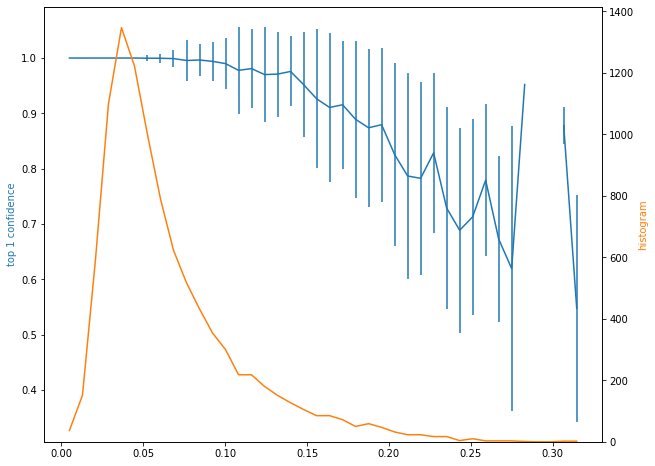

In [236]:
bins = 40
mean_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'mean', bins=bins)
std_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'std', bins=bins)
count_stats, binedges, binnumber = scipy.stats.binned_statistic(min_val, conf_imagenet, 'count', bins=bins)
fig, ax = plt.subplots(figsize=(10, 8))
ax.errorbar(binedges[:-1], mean_stats, yerr=std_stats, color='tab:blue')
# ax.tick_params(axis='y', colors='tab:blue')
ax.set_ylabel('top 1 confidence', color='tab:blue')

ax_twin = ax.twinx()
ax_twin.plot(binedges[:-1], count_stats, color='tab:orange')
# ax_twin.tick_params(axis='y', colors='tab:orange')
ax_twin.set_ylabel('histogram', color='tab:orange')
ax_twin.set_ylim(0, None)
# plt.savefig('memdist-quality(inception_v3_from_scratch).pdf', bbox_inches='tight')